In [11]:
# Design State Feedback Reference Tracking

import control
from control import ctrb, obsv, place

import numpy as np
from numpy.linalg import eig, matrix_rank
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from numpy import kron, eye, zeros, hstack, vstack
from scipy.linalg import solve

In [12]:
# Example
A = np.array([[0, 1], 
              [-1, 0]])
B = np.array([[0], 
              [1]])
C = np.array([[1, 0]])

#print(A)

In [13]:
# Exosystem
S = np.array([[0,1],[0,0]])

# Reference signal and matrix
R = np.array([[1,0]])

In [14]:
# Compute eigenvalues, eigenvectors
w,v = eig(A)
print('eigenvalues:', w)

eigenvalues: [0.+1.j 0.-1.j]


In [15]:
# Controllability matrix
W_c = ctrb(A, B)
matrix_rank(W_c)

np.int64(2)

In [16]:
# Design F1 s.t. A+BF1 is stable
desired_control_poles = [-1, -2]
F1 = -place(A,B,desired_control_poles)

# confirm desired eigenvalues
print(eig(A+B*F1))
#print(F1)

EigResult(eigenvalues=array([-1., -2.]), eigenvectors=array([[ 0.70710678, -0.4472136 ],
       [-0.70710678,  0.89442719]]))


In [17]:
# Design of F2 and F
# AX-XS+BU=0 & -CX+R=0
# From -CX+R=0 we have -[1 0][X11 X12; X21 X22]+[1 0]=0, so X11=1 and X12=0
# From [0 1; -1 0][1 0; X21 X22]-[1 0; X21 X22][0 1; 0 0]+[0 1]'[U1 U2]=0
# we have [X21 X22; -1 0]-[0 1; 0 X21]+[0 0; U1 U2]=0
# so X21=0, X22=1, U1=1, U2=0
#X = np.array([[1, 0], [0, 1]])
#U = np.array([[1,0]])

def regulator(A, B, C, S, R):
    """
    Solve: AX - XS + BU = 0 and CX = R
    Returns X, U
    """

    # get signal sizes
    n, q, m = A.shape[0], S.shape[0], B.shape[1]

    # Vectorization: vec(X) stacks all columns of X into one long vector
    """
    (I⊗A - S^T⊗I)vec(X) + (I⊗B)vec(U) = 0
    (I⊗C)vec(X) = vec(R)
    """
    A_sys = vstack([
        hstack([kron(eye(q), A) - kron(S.T, eye(n)), kron(eye(q), B)]),
        hstack([kron(eye(q), C), zeros((q, m*q))])
    ])

    # Vectorized system of linear equation
    """
    [ I⊗A - S^T⊗I  |  I⊗B ] [vec(X)]   [0    ]
    [ I⊗C          |  0   ] [vec(U)] = [vec(R)]
    """
    sol = solve(A_sys, hstack([zeros(n*q), R.flatten()]))
    
    return sol[:n*q].reshape(n, q, order='F'), sol[n*q:].reshape(m, q, order='F')

X, U = regulator(A, B, C, S, R)

# From F2 = U-F1*X we have
F2 = U - F1 @ X

F = np.block([F1, F2])
print(F)

[[-1. -3.  2.  3.]]


In [18]:
# Closed-loop system matrix
A_cl = np.block([
    [A + B @ F1,  B @ F2],
    [np.zeros((2,2)),      S]
])

print(A_cl)

w_cl,v_cl = eig(A_cl)
print('eigenvalues:', w_cl)

[[ 0.  1.  0.  0.]
 [-2. -3.  2.  3.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  0.]]
eigenvalues: [-1. -2.  0.  0.]


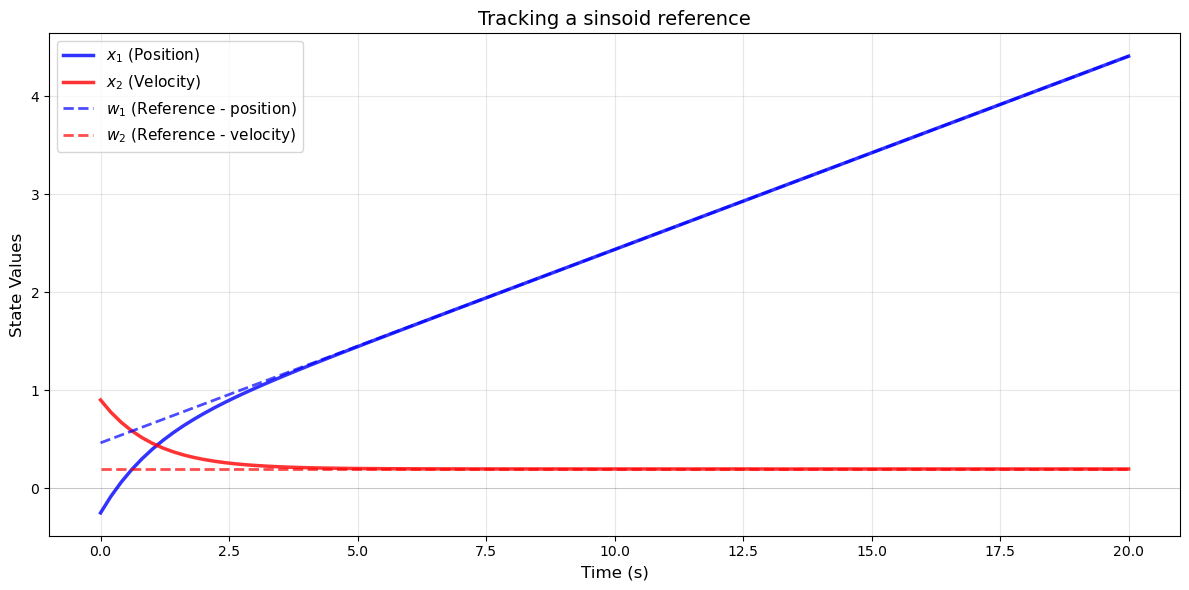

In [19]:
# Plot
def f(t, x):
    return A_cl @ x

t0, t1 = 0, 20                # start and end
t_span = (t0, t1)
t_eval = np.linspace(t0, t1, 100)  # the points of evaluation of solution             

# Initial condition
np.random.seed(42)  # For reproducibility         
x0 = np.random.uniform(-1, 1, size=4) # initial value
#print(x0)

# Solve ODE using modern solve_ivp
sol = solve_ivp(f, t_span, x0, t_eval=t_eval)

# Plot the results
plt.figure(figsize=(12, 6))

plt.plot(sol.t, sol.y[0], 'b-', linewidth=2.5, label='$x_1$ (Position)', alpha=0.8)
plt.plot(sol.t, sol.y[1], 'r-', linewidth=2.5, label='$x_2$ (Velocity)', alpha=0.8)
plt.plot(sol.t, sol.y[2], 'b--', linewidth=2, label='$w_1$ (Reference - position)', alpha=0.7)
plt.plot(sol.t, sol.y[3], 'r--', linewidth=2, label='$w_2$ (Reference - velocity)', alpha=0.7)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('State Values', fontsize=12)
plt.title('Tracking a sinsoid reference', fontsize=14)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.2, linewidth=0.5)
plt.tight_layout()
plt.show()

[[-1.  0.  1.  0.]]


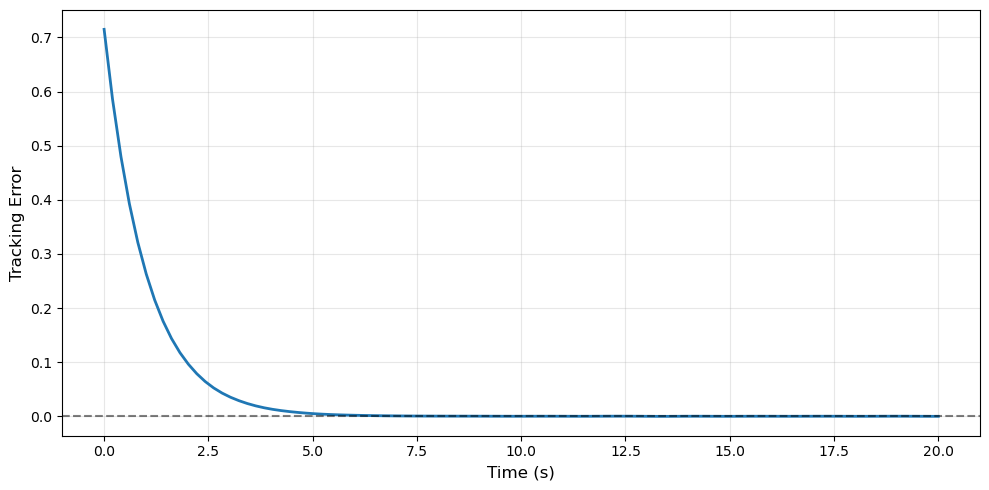

In [20]:
# Tracking error (simplified)
E = np.block([np.zeros((1, 2))-C, R])
print(E)

e = E @ sol.y  # Direct matrix multiplication

plt.figure(figsize=(10, 5))
plt.plot(sol.t, e.T, linewidth=2)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Tracking Error', fontsize=12)
#plt.title('Tracking Error over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()